In [18]:
import time
import tweepy
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import datetime
from collections import Counter
import random
from math import sqrt
from wordcloud import WordCloud,STOPWORDS
import pytz

In [19]:
use_omer_key = True

if use_omer_key:
    consumer_key = 'dA43DArrQ3nV0l7iWOz993VMI'
    consumer_secret = 'afx745bNRb3W0vqchR4Mtt4haid7i0Gi1gLS9vgTTZsuSpEl9z'
    access_token = '771948456793477120-ZYkhquAETkTlr6Gt45EsDose3kWJwT5'
    access_token_secret = 'BCSXX2Kf6nc3NPIsIWPRM2xPTD3ZAOXyQq93kVPzu3hSd'
else:
    consumer_key = 'AvbJmfCFfVGjDs6onNpJCRYQw'
    consumer_secret = 'NCl7cReKJ2v63bsiaZStYTRYADQzqLLw0vwSwTC1RWk6AGtfQp'
    access_token = '1287676006757740545-ZO1BIVhXCLikmrgF13V3YeAUSu7kKd'
    access_token_secret = 'cDE2Zz5fhhOi9bJSeIHNhRvP77i3FUay50HE02yChjzTt'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [20]:
# import pytz

# utc=pytz.UTC

# num_tweets = 100
# lang = 'en'
# query = '#politics'
# print_progress = True
# until = utc.localize(datetime.datetime.today())
# since = until - datetime.timedelta(days=7)
# print((until, since))
    
# min_tweet_date = until
# tweets = []
# while True:
#     current_tweets_counter = 0
#     for tweet in tweepy.Cursor(api.search_tweets, q=query, geocode=f'37.6,-95.665,{sqrt((9_000_000)/3.14)}km', 
#                                lang=lang, until=str(until).split(' ')[0]).items():        
#         tweets.append(tweet)
#         current_tweets_counter += 1
#         # print(len(tweets), tweet.created_at, tweet.user.location)
#         min_tweet_date = min(tweet.created_at,
#                              min_tweet_date)
#         if current_tweets_counter == num_tweets:
#             until = min_tweet_date - datetime.timedelta(hours=np.random.randint(4))
#             print(until)
#             with open(f'pickles/{query[1:]}_tweets.pkl', 'wb') as f:
#                 pickle.dump(tweets, f)
#             break
#     if min_tweet_date < since:
#         break

In [21]:
utc=pytz.UTC
num_tweets = 1_000_000_000
lang = 'en'
query = '#sports'
print_progress = True
until = utc.localize(datetime.datetime.today())
since = until - datetime.timedelta(days=7)
print((until, since))
    
min_tweet_date = until
tweets = []
current_tweets_counter = 0
for tweet in tweepy.Cursor(api.search_tweets, q=query, geocode=f'37.6,-95.665,{sqrt((9_000_000)/3.14)}km', 
                           lang=lang, until=str(until).split(' ')[0]).items():        
    tweets.append(tweet)
    current_tweets_counter += 1
    # print(len(tweets), tweet.created_at, tweet.user.location)
    if current_tweets_counter % 1_000 == 0:
        print(f'Nuber of tweets: {len(tweets)}')
        print(f'Current date: {tweet.created_at}')
        with open(f'pickles/{query[1:]}_tweets.pkl', 'wb') as f:
            pickle.dump(tweets, f)
    min_tweet_date = min(tweet.created_at,
                         min_tweet_date)
    if current_tweets_counter == num_tweets:
        break

(datetime.datetime(2022, 7, 14, 20, 20, 5, 986560, tzinfo=<UTC>), datetime.datetime(2022, 7, 7, 20, 20, 5, 986560, tzinfo=<UTC>))
Nuber of tweets: 1000
Current date: 2022-07-12 01:54:29+00:00
Nuber of tweets: 2000
Current date: 2022-07-10 16:01:10+00:00


Rate limit reached. Sleeping for: 574


Nuber of tweets: 3000
Current date: 2022-07-08 14:46:16+00:00
Nuber of tweets: 4000
Current date: 2022-07-07 07:15:59+00:00
Nuber of tweets: 5000
Current date: 2022-07-05 23:55:22+00:00


Rate limit reached. Sleeping for: 787


In [32]:
with open(f'pickles/{query[1:]}_tweets.pkl', 'rb') as f:
    tweets = pickle.load(f)
    
print(len(tweets))

5000


In [33]:
def explode(df, col):
    s = df[col].apply(pd.Series).add_prefix(col + '_')
    return pd.concat([df.drop([col], axis=1), s], axis=1)

def create_date_columns(original_df):
    df = original_df.copy()
    df['created_at'] = df['created_at']\
        .apply(lambda x: datetime.datetime.strptime(x, '%a %b %d %H:%M:%S %z %Y'))
    df['year'] = df['created_at'].apply(lambda x: x.year)
    df['month'] = df['created_at'].apply(lambda x: x.month)
    df['day'] = df['created_at'].apply(lambda x: x.day)
    df['hour'] = df['created_at'].apply(lambda x: x.hour)
    return df

def filter_tweets_by_user_count(df, lb=10, ub=30):
    n_rows_before = df.shape[0]
    users_df = df[['id', 'user_id']].groupby('user_id').count()
    users_df = users_df[(users_df.id > lb) & (users_df.id < ub)]
    res = df[df.user_id.isin(users_df.index)]
    n_rows_after = res.shape[0]
    print(f'Removed {n_rows_before - n_rows_after} out of {n_rows_before} rows.')
    return res

def create_scaled_favorite_count(df_original):
    df = df_original.copy()
    user_stats = df[['user_id', 'favorite_count']].groupby('user_id').agg(['mean', 'std', 'count'])
    mean = user_stats[('favorite_count',  'mean')]
    std = user_stats[('favorite_count',  'std')]
    mu = lambda uid: mean[mean.index == uid].values[0]
    sigma = lambda uid: std[std.index == uid].values[0]
    df['scaled_favorite_count'] = df.apply(lambda row: (row['favorite_count'] - mu(row['user_id'])) / sigma(row['user_id']), axis = 1)
    return df

In [34]:
df = pd.DataFrame([t._json for t in tweets])
df = df.drop_duplicates(subset='id')
df = explode(df, 'user')
df = create_date_columns(df)
df = filter_tweets_by_user_count(df, lb=1, ub=100)
df = create_scaled_favorite_count(df)
df = df[df['scaled_favorite_count'].notna()]
print(f'Number of rows: {df.shape[0]}')

Removed 2940 out of 5000 rows.


C:\Users\omerm\AppData\Local\Temp\ipykernel_20112\558941812.py:31: RuntimeWarning: invalid value encountered in double_scalars
  df['scaled_favorite_count'] = df.apply(lambda row: (row['favorite_count'] - mu(row['user_id'])) / sigma(row['user_id']), axis = 1)


Number of rows: 1692


In [35]:
def plot_user_counts_distribution(df):
    user_tweet_counts = df[['id', 'user_id']].groupby('user_id').count().values
    user_tweet_counts = sorted([x[0] for x in user_tweet_counts])
    plt.hist(user_tweet_counts, bins=20)
    plt.xlabel('number of tweets')
    plt.ylabel('number of users')
    plt.show()
    
def plot_hours_distribution(df):
    hour_tweet_counts = df[['id', 'hour']].groupby('hour').count()
    hours, counts = hour_tweet_counts['id'].index, hour_tweet_counts['id'].values
    plt.bar(hours, counts)
    plt.xlabel('publication hour')
    plt.ylabel('number of tweets')
    plt.show()
    
def plot_days_distribution(df):
    days_tweet_counts = df[['id', 'day']].groupby('day').count()
    days, counts = days_tweet_counts['id'].index, days_tweet_counts['id'].values
    days = [str(d) for d in days]
    plt.bar(days, counts)
    plt.xlabel('publication day')
    plt.ylabel('number of tweets')
    plt.show()
    
def plot_days_hours_distribution(df):
    days_hours_tweet_counts = df[['id', 'day', 'hour']].groupby(['day', 'hour']).count()
    days_hours, counts = days_hours_tweet_counts['id'].index, days_hours_tweet_counts['id'].values
    days_hours = [str(t) for t in days_hours]
    plt.bar(days_hours, counts)
    plt.xlabel('publication day and hour')
    plt.ylabel('number of tweets')
    plt.xticks([], [])
    plt.show()
    
def plot_scaled_favorite_count(df):
    plt.hist(df['scaled_favorite_count'])
    plt.xlabel('scaled favorite count')
    plt.ylabel('number of tweets')
    plt.show()
    
def wordcloud(df, additional_stopwords=("https", "t", "co", "S", "U")):
    text = " ".join(tweet for tweet in df.text)
    stopwords = set(STOPWORDS)
    stopwords.update(additional_stopwords)

    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

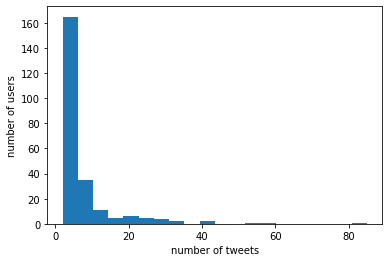

In [36]:
plot_user_counts_distribution(df)

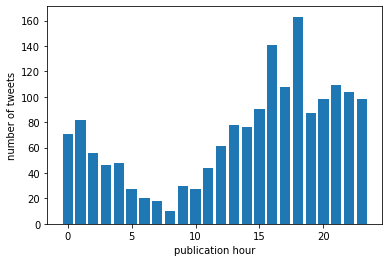

In [37]:
plot_hours_distribution(df)

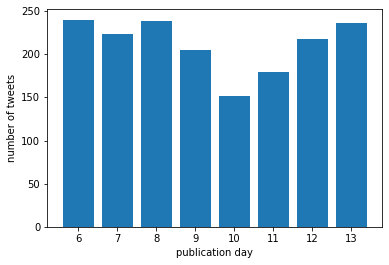

In [38]:
plot_days_distribution(df)

C:\Users\omerm\AppData\Local\Temp\ipykernel_20112\2803902604.py:33: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([], [])


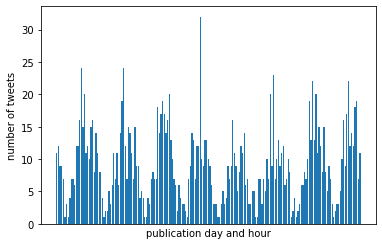

In [39]:
plot_days_hours_distribution(df)

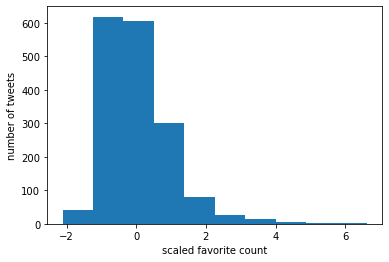

In [40]:
plot_scaled_favorite_count(df)

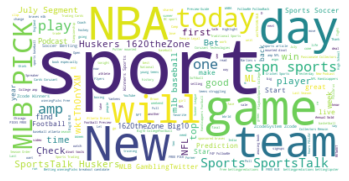

In [41]:
wordcloud(df)